#### Movie sentiment model - GRU

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray
from numpy import zeros
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [2]:
def getGloveEmbeddings(glovefolderpath):
    print("---------------------- Getting Glove Embeddings -------------------------\n")
    embeddings_dictionary = dict()
    glove_file = open(f"{glovefolderpath}", encoding="utf8")
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    glove_file.close()
    print("----------------------  -------------------------\n")
    return embeddings_dictionary


glove_folder=r'D:/STUDY/Sem3/deeplearning/glove.6B/glove.6B.100d.txt'

In [3]:
maxlen = 100

In [4]:
dataset =  pd.read_csv('movie_data.csv')

X = dataset['review'].values
y = dataset['sentiment'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
tokeniser = tf.keras.preprocessing.text.Tokenizer()
tokeniser.fit_on_texts(X_train)


# Save the tokenizer using pickle
with open('tokenizer_movie_gru.pickle', 'wb') as handle:
    pickle.dump(tokeniser, handle, protocol=pickle.HIGHEST_PROTOCOL)


X_train = tokeniser.texts_to_sequences(X_train)
X_test = tokeniser.texts_to_sequences(X_test)
vocab_size = len(tokeniser.word_index) + 1

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

In [7]:
embeddings_dictionary=getGloveEmbeddings(glove_folder)
embedding_matrix = zeros((vocab_size, maxlen))
for word, index in tokeniser.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

---------------------- Getting Glove Embeddings -------------------------

----------------------  -------------------------



In [8]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim= maxlen, weights=[embedding_matrix], input_length=maxlen , trainable=False),
    tf.keras.layers.GRU(maxlen),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])     
 
print(model.summary())

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', patience=10)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          10591700  
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10652401 (40.64 MB)
Trainable params: 60701 (237.11 KB)
Non-trainable params: 10591700 (40.40 MB)
_________________________________________________________________
None


In [9]:
history=model.fit(x=X_train,
        y=y_train,
        epochs=100,
        callbacks=[early_stop],
        validation_split=0.3
         )

Epoch 1/100
766/766 [==============================] - 41s 51ms/step - loss: 0.5112 - accuracy: 0.7408 - val_loss: 0.4424 - val_accuracy: 0.7906
Epoch 2/100
766/766 [==============================] - 39s 51ms/step - loss: 0.3865 - accuracy: 0.8234 - val_loss: 0.3741 - val_accuracy: 0.8330
Epoch 3/100
766/766 [==============================] - 38s 49ms/step - loss: 0.3418 - accuracy: 0.8473 - val_loss: 0.3578 - val_accuracy: 0.8444
Epoch 4/100
766/766 [==============================] - 39s 51ms/step - loss: 0.3104 - accuracy: 0.8653 - val_loss: 0.3519 - val_accuracy: 0.8446
Epoch 5/100
766/766 [==============================] - 40s 52ms/step - loss: 0.2721 - accuracy: 0.8819 - val_loss: 0.3361 - val_accuracy: 0.8510
Epoch 6/100
766/766 [==============================] - 40s 52ms/step - loss: 0.2412 - accuracy: 0.8972 - val_loss: 0.3429 - val_accuracy: 0.8540
Epoch 7/100
766/766 [==============================] - 41s 54ms/step - loss: 0.2082 - accuracy: 0.9143 - val_loss: 0.3459 - val_ac

In [10]:
def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print(f"Accuracy : {str(round(acc_sc,2)*100)}")
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')
   plt.show()

469/469 [==============================] - 9s 18ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      7443
           1       0.86      0.81      0.84      7557

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000

Accuracy : 84.0


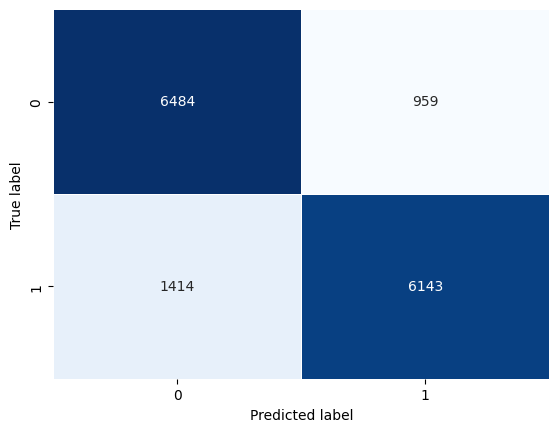

In [11]:
preds = (model.predict(X_test) > 0.5).astype("int32")
c_report(y_test, preds)
plot_confusion_matrix(y_test, preds)

In [12]:
# Save the model
model.save("gru_movie_model.h5")

d:\STUDY\Sem3\deeplearning\DLENV\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Load the saved model
gru_movie_model = tf.keras.models.load_model('gru_movie_model.h5')

# Function to predict sentiment for a given review
def gru_predict_sentiment(review):
    sequence = tokeniser.texts_to_sequences([review])
    sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post', maxlen=maxlen)
    prediction = gru_movie_model.predict(sequence)
    if prediction > 0.5:
        return "Positive"
    else:
        return "Negative"

In [14]:
# Test the model prediction
example_review = "This movie was fantastic! I loved every bit of it."
prediction_result = gru_predict_sentiment(example_review)
print(f"Review: {example_review} \nThe sentiment is predicted as: {prediction_result}")

1/1 [==============================] - 1s 571ms/step
Review: This movie was fantastic! I loved every bit of it. 
The sentiment is predicted as: Positive


In [15]:
# Test the model prediction
example_review = "This movie was very bad! I hated every bit of it."
prediction_result = gru_predict_sentiment(example_review)
print(f"Review: {example_review} \nThe sentiment is predicted as: {prediction_result}")

1/1 [==============================] - 0s 51ms/step
Review: This movie was very bad! I hated every bit of it. 
The sentiment is predicted as: Negative
